# Resnet Feature Extraction

In [1]:
%matplotlib inline

from fastai import *
from fastai.vision import *
from scipy.spatial import distance
import faiss 

In [71]:
PATH = Path("/home/sairahul/myfiles/fastai_cmd/datasets/cifar10")
bs = 512

In [131]:
def create_feature_extraction_model(model, cut=None):
    body = create_body(model, cut=cut)
    for param in body.parameters():
        param.requires_grad = False
    return body

In [166]:
def extract_features(model, dirname, batch_size=512):
    dirname = Path(dirname)
    allfiles = [each_file for each_file in dirname.glob("*/*")]
    image_features = []
    for i in range(0, len(allfiles), batch_size):
        batch_files = allfiles[i:i+batch_size]
        
        img_batch = []
        for img in batch_files:
            img = open_image(img)
            img_batch.append(img.data)
        
        img_batch = torch.stack(img_batch, 0)
        features = model(img_batch.cuda())
        features = features.cpu()
        
        for img, feature in zip(batch_files, features):
            image_features.append(feature.flatten().numpy())
    
    return allfiles, np.stack(image_features, axis=0)

In [150]:
def display_closest(index, query_index, files, image_features):
    get_lbl = lambda fn: str(fn).split('/')[-2]

    dists, indexes = index.search(image_features[query_index][None,:], 12)

    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    fn = files[query_index]
    ax = axes[0][0]
    
    show_image(open_image(fn), ax=ax)
    axes[0][0].set_title(get_lbl(fn))
    for ax in axes[0][1:]:
        ax.axis('off')
    for i,ax in enumerate(axes.flat[4:]):
        fn = files[indexes[0][i]]
        show_image(open_image(fn), ax=ax)
        ax.set_title(get_lbl(fn))

## Extracting feature vectors

In [4]:
resnet34 = create_feature_extraction_model(models.resnet34)
resnet34 = resnet34.cuda()

In [9]:
files, image_features = extract_features(resnet34, PATH/"train")

## Creating index 

In [11]:
index = faiss.IndexFlatL2(512)
index.add(image_features)

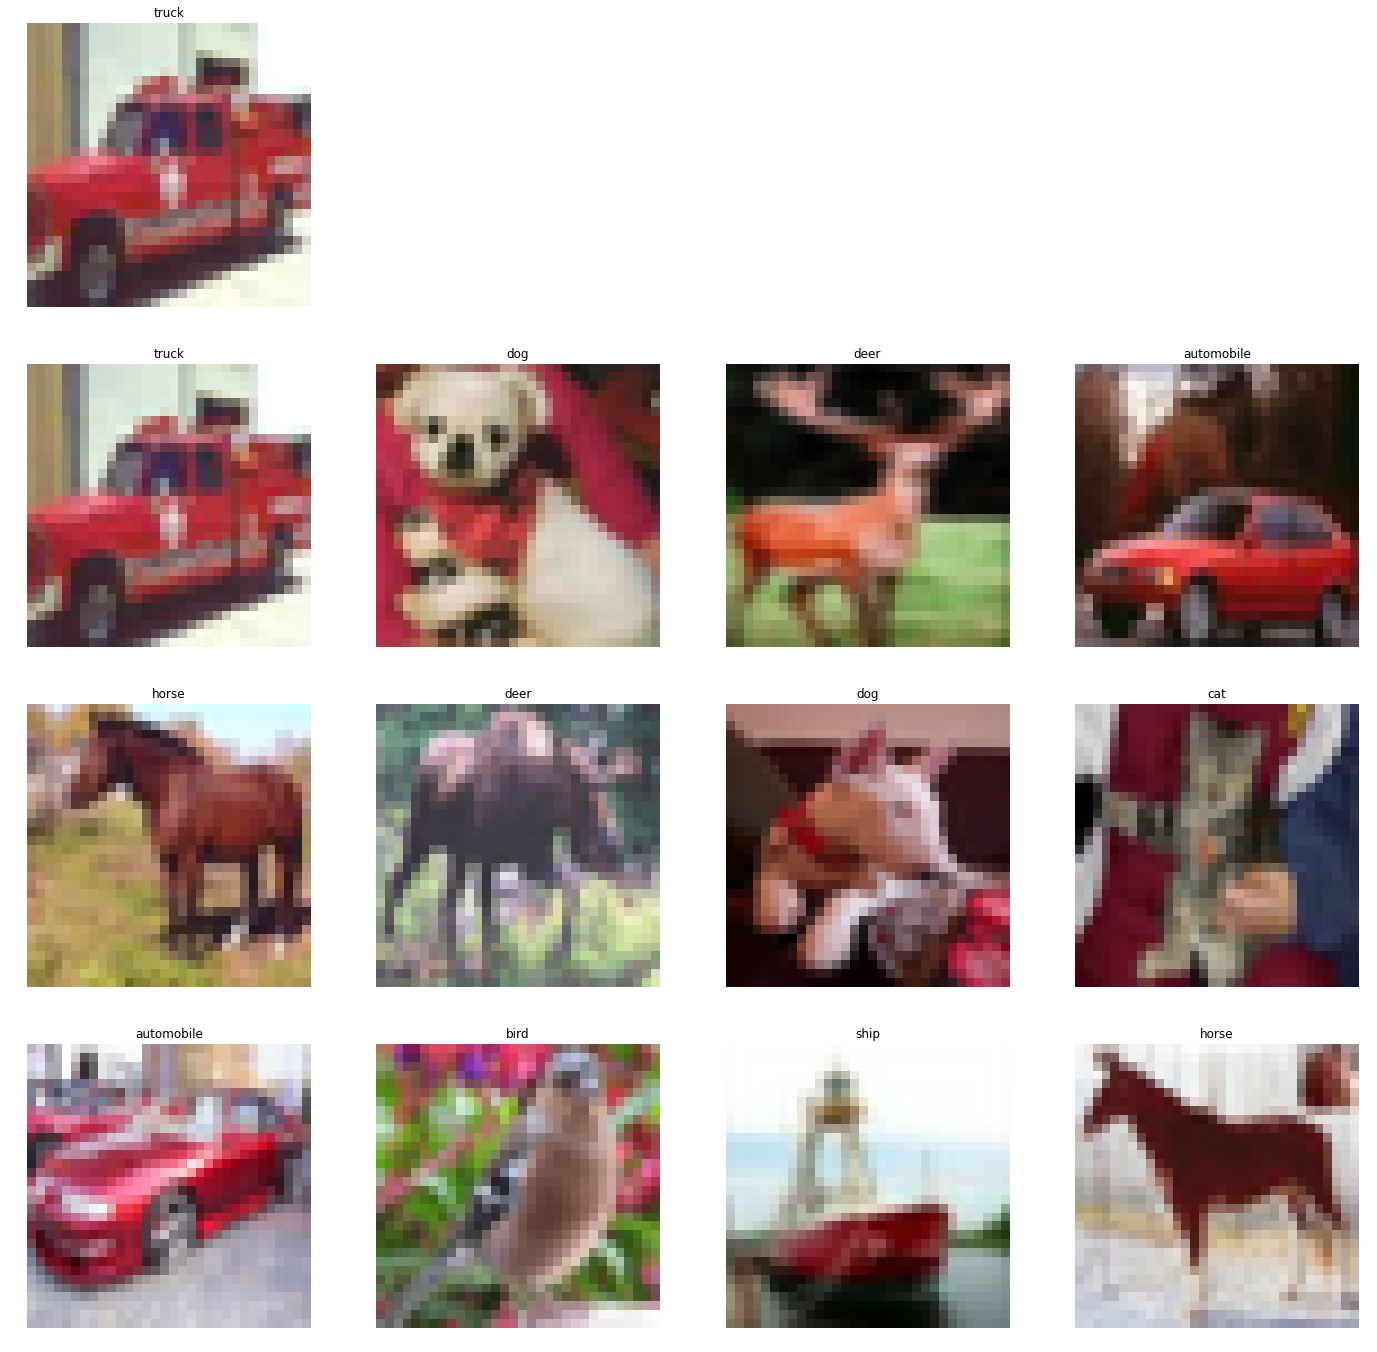

In [68]:
display_closest(index, 5001, files, image_features)

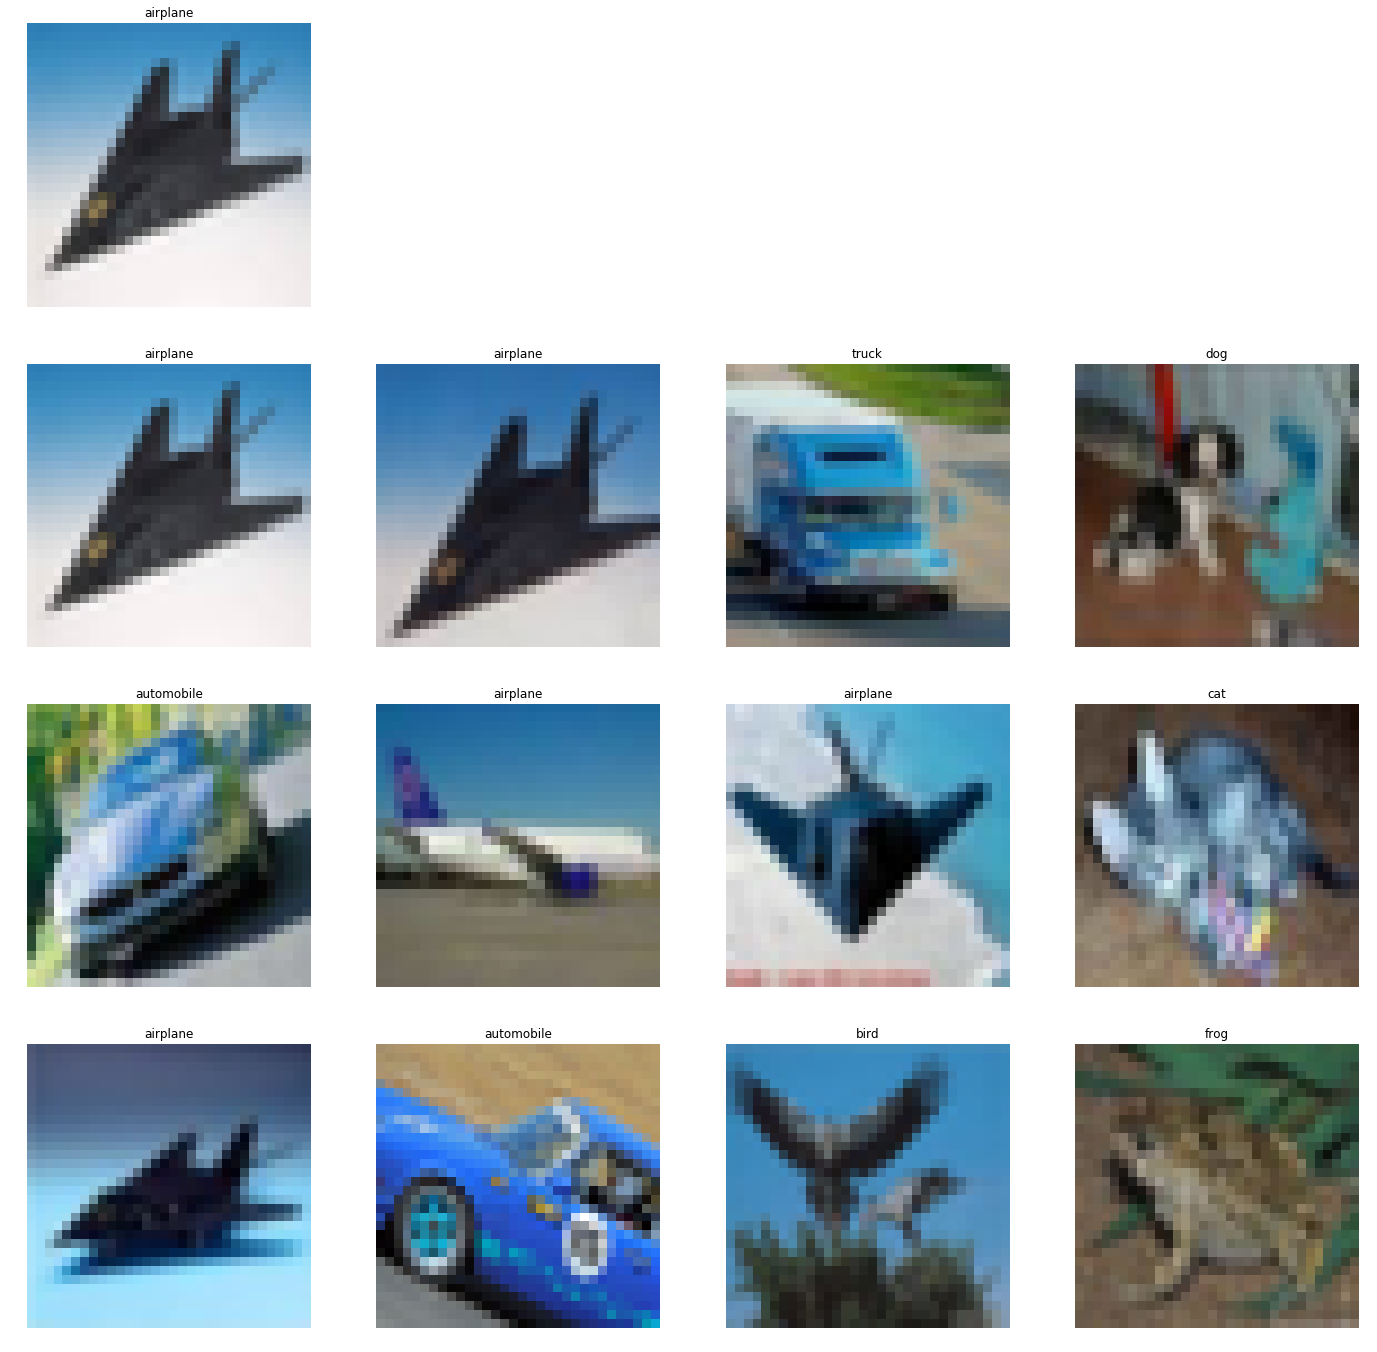

In [151]:
display_closest(index, 0, files, image_features)

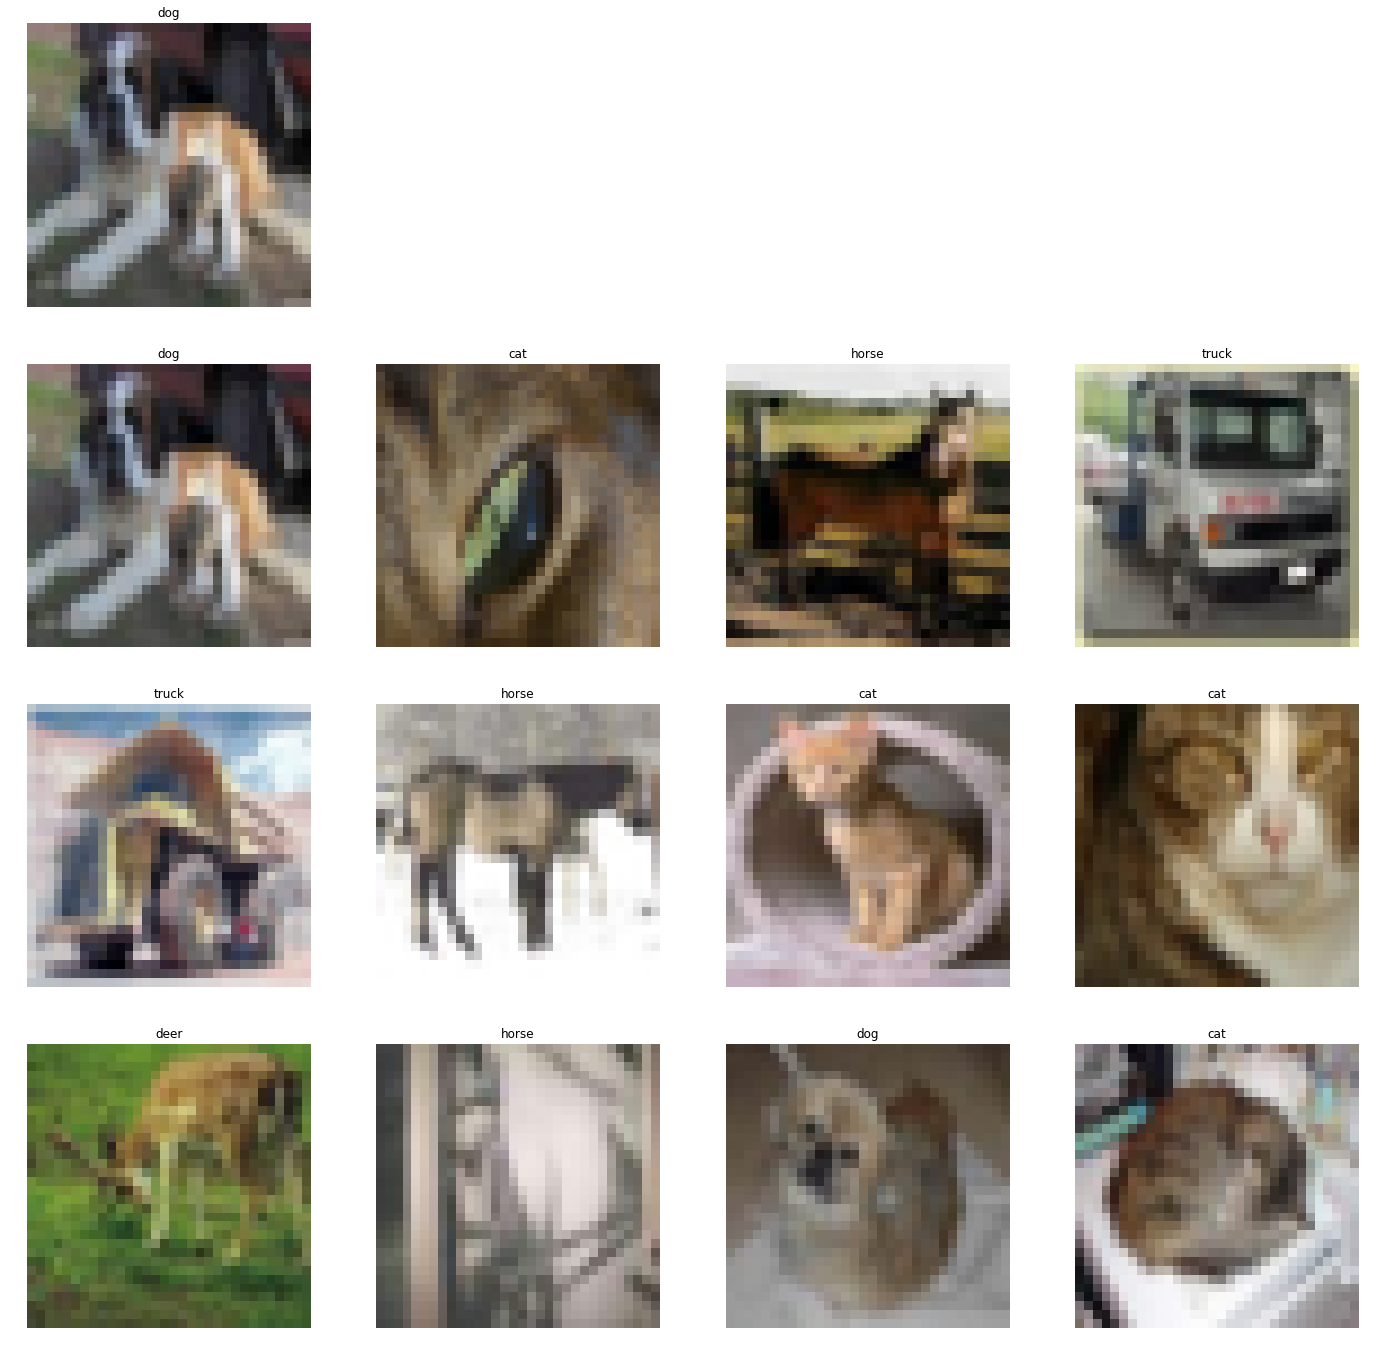

In [69]:
display_closest(index, 10001, files, image_features)

# Train cifar10

In [78]:
ds_tfms = ([*rand_pad(4, 32), flip_lr(p=0.5)], [])
data = (ImageDataBunch.from_folder(PATH, ds_tfms=ds_tfms, valid='test', bs=bs).normalize(imagenet_stats))

In [122]:
learn = cnn_learner(data, models.resnet34)
learn.loss_func = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


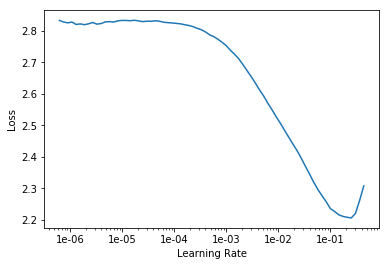

In [118]:
learn.lr_find()
learn.recorder.plot()

In [123]:
learn.fit_one_cycle(15, max_lr=2e-3, div_factor=20., pct_start=0.8, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,accuracy,time
0,2.283794,1.852100,0.368900,00:07
1,1.940332,1.560563,0.464700,00:07
2,1.651435,1.328768,0.533600,00:07
3,1.404944,1.161185,0.588100,00:07
4,1.220260,1.026087,0.633300,00:07
5,1.085629,0.928325,0.671400,00:07
6,0.973686,0.856019,0.698900,00:07
7,0.898101,0.791788,0.719800,00:07
8,0.845080,0.766427,0.733000,00:07
9,0.806301,0.731591,0.741800,00:07


In [124]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


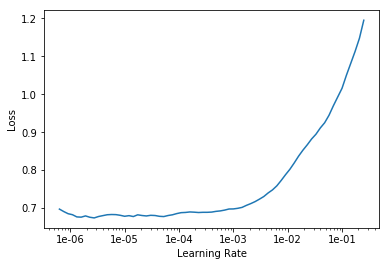

In [125]:
learn.lr_find()
learn.recorder.plot()

In [126]:
learn.fit_one_cycle(20, max_lr=2e-4, div_factor=30., pct_start=0.9, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.669913,0.623055,0.779400,00:09
1,0.645768,0.608119,0.785100,00:09
2,0.625882,0.585763,0.795600,00:09
3,0.597987,0.564919,0.802100,00:09
4,0.569455,0.544748,0.808300,00:09
5,0.540241,0.522150,0.815700,00:09
6,0.516784,0.511902,0.819700,00:09
7,0.486638,0.495134,0.828800,00:09
8,0.462740,0.491436,0.830300,00:09
9,0.427238,0.474750,0.837500,00:09


In [128]:
learn.save('pretrained-cifar10-1')

In [170]:
finetuned_model = [x for x in learn.model.children()]
finetuned_model = finetuned_model[0]
for param in finetuned_model.parameters():
    param.requires_grad = False

In [171]:
new_files, new_image_features = extract_features(finetuned_model, PATH/"train")

In [174]:
new_index = faiss.IndexFlatL2(512)
new_index.add(new_image_features)

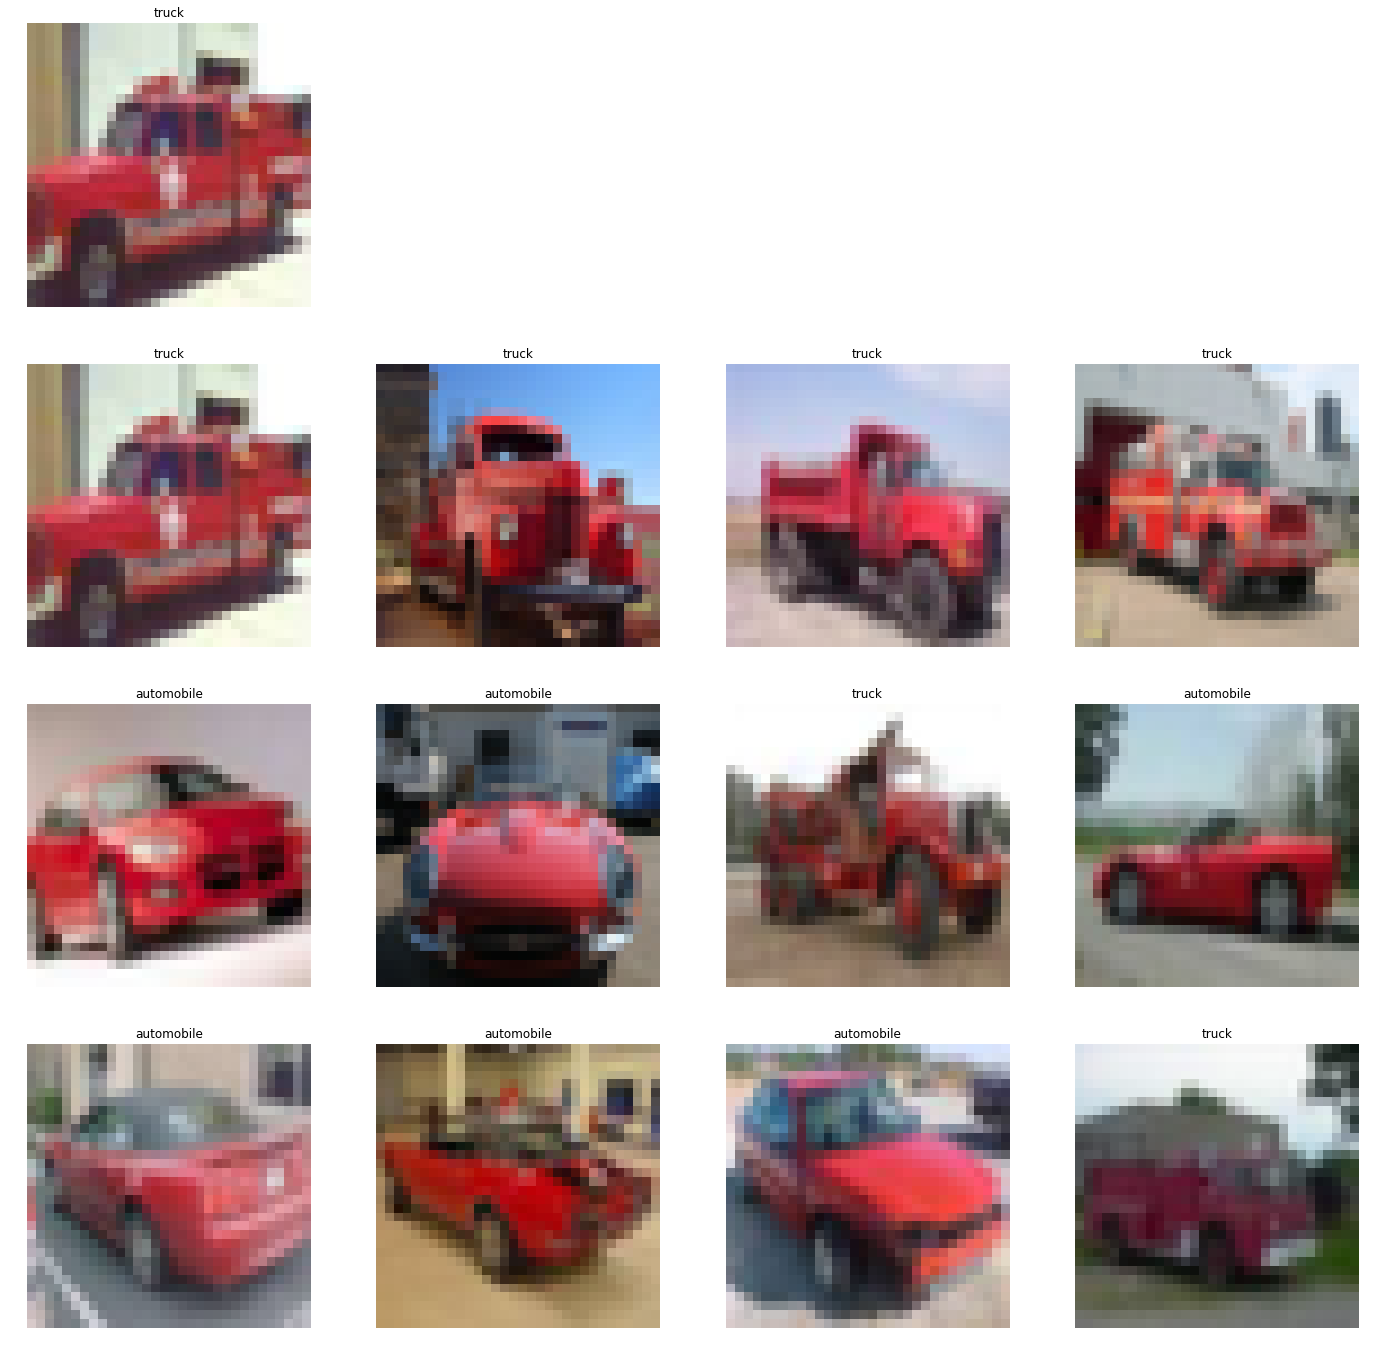

In [175]:
display_closest(new_index, 5001, new_files, new_image_features)

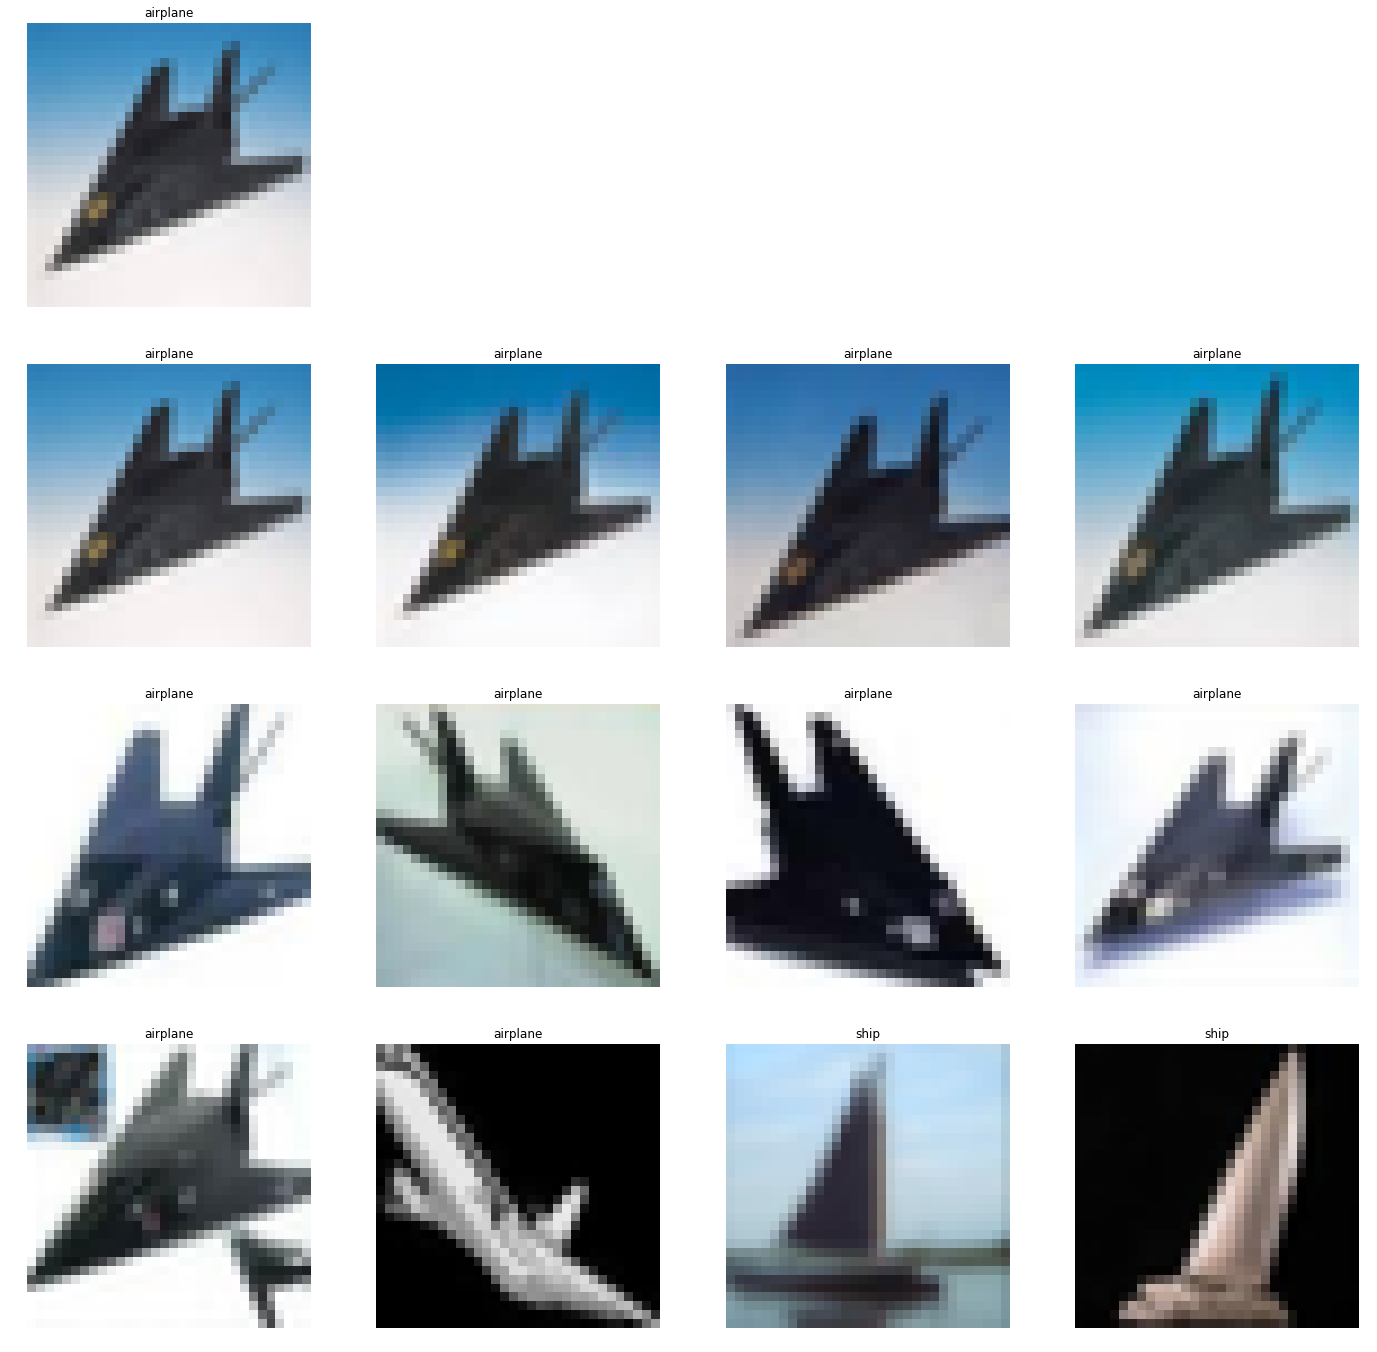

In [176]:
display_closest(new_index, 0, new_files, new_image_features)

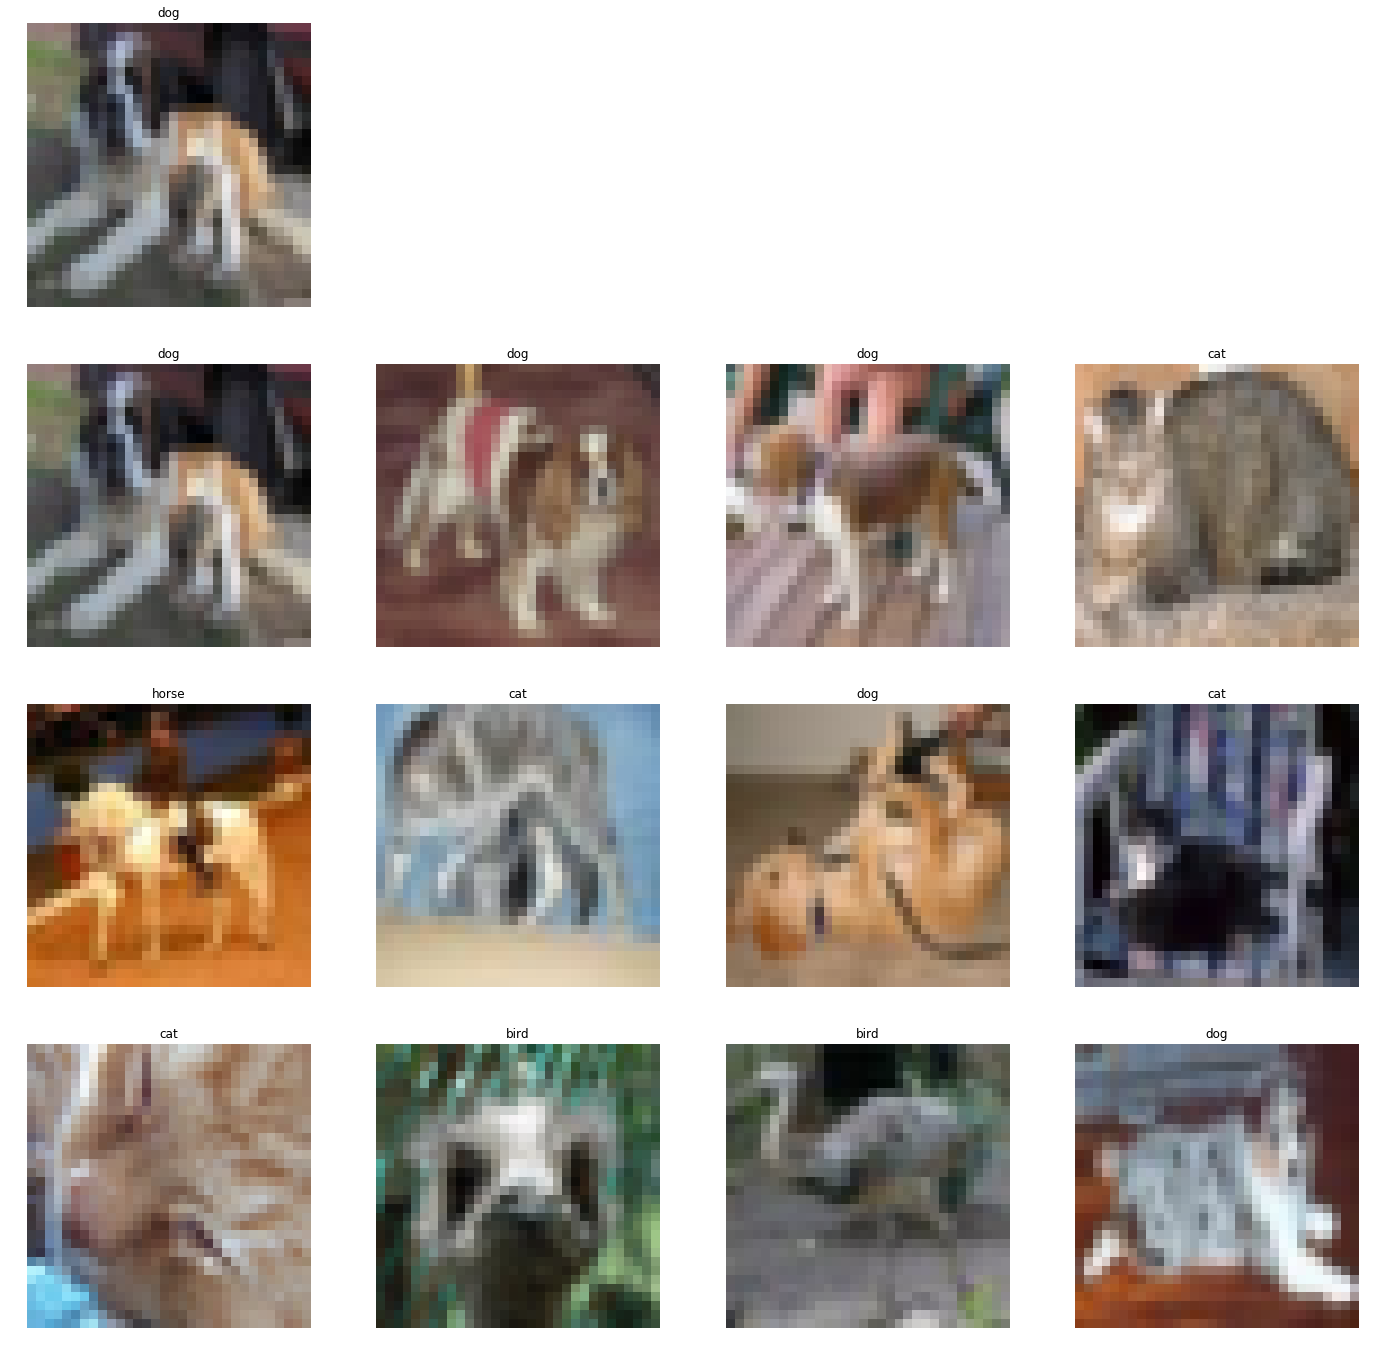

In [177]:
display_closest(new_index, 10001, files, new_image_features)